# TA SESSION 3

## Complete Machine Learning Pipeline

Remember to run:

``` shell
uv sync
````

in the directory of the repo before starting to run this notebook.

In [1]:
"""
Choose the configuration of your pipeline by using the variables below.
The options for each variable are:
    - NORM: Whether to normalize the data; True/False
    - SEL: Whether to use only the most important features; True/False
    - FILL: Whether to fill missing values using K-Nearest Neighbors; True/False
    - SMOTE: Whether to use SMOTE for oversampling the imbalanced class; True/False
    - KEY: Whether to one-hot encode the key variable or drop it (creates 10 new variables if True!); True/False
    - COMPAS: Whether to binarize the time_signature variable or to drop it completely; True/False
    - LOG: Whether to apply log transformation to duration, loudness, speechiness, instrumentalness and liveness; True/False
    - WIND: Whether to winsorize duration and tempo
    - GENRE: Whether to use target encoding for the track_genre variable or drop it; True/False
    - MODEL: Which model to use;    LC (Logistic Classifier)
                                    RF (Random Forest)
                                    GB (Gradient Boosting Model)
                                    NN (Simple Neural Network)
                                    SVM (Support Vector Machine) - I recommend you don't use it unless you know how to check whether your model is taking too long to fit :)
"""

NORM = False
SEL = False
FILL = False
SMOTE = False
KEY = False
COMPAS = False
LOG = False
WIND = False
GENRE = False
MODEL = "LC"



rf_n_estim = 10
gb_n_estim = 10  # I absolutely recommend against using more than 10 without first trying out how fast your computer processes each step




EDA = False # This is just for me, so that when I run it while creating the pipeline I don't have to wait 10-20 additional second for all the plots to be generated

## Imports

In [2]:
# !pip install scikit-learn
# !pip install pandas numpy matplotlib seaborn

In [3]:
from ucimlrepo import list_available_datasets, fetch_ucirepo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

np.random.seed(98)

In [4]:
df = pd.read_parquet("../data/spotify/spotify.parquet")
df = df.drop(columns=["Unnamed: 0"])

target = "popularity"  # Try changing this to "danceability" and see what happens with the EDA!

<Axes: >

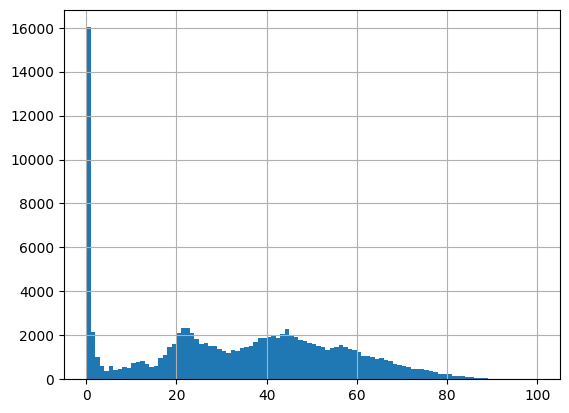

In [5]:
df[target].hist(bins=100)

In [6]:
display(df[target].describe())
median = df[target].median()
print(median)

count    114000.000000
mean         33.238535
std          22.305078
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

35.0


In [7]:
display(df[df[target] == median].shape[0])

1460

In [8]:
df_og = df.copy()

In [9]:
df = df[df[target] != median].copy()
df["temp_target"] = np.where(df[target] > median, 1, 0)
df.reset_index(drop=True, inplace=True)

df_target_copy = df[target].copy()

print(df[df["temp_target"] == 0].shape)
print(df[df["temp_target"] == 1].shape)

(56991, 21)
(55549, 21)


In [10]:
# We drop the original danceability column and rename the new one
df.drop(columns=[target], inplace=True)
df.rename(columns={"temp_target": target}, inplace=True)

df

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112535,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,0
112536,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,0
112537,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,0
112538,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,1


## EDA for reference

In [11]:
display(df)

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112535,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,0
112536,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,0
112537,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,0
112538,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,1


In [12]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
str_cols = df.select_dtypes(include="object").columns.tolist()

print("Numeric columns:", num_cols)
print("String columns:", str_cols)

print("\n")

df.info()

Numeric columns: ['duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'popularity']
String columns: ['track_id', 'artists', 'album_name', 'track_name', 'track_genre']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112540 entries, 0 to 112539
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          112540 non-null  object 
 1   artists           112539 non-null  object 
 2   album_name        112539 non-null  object 
 3   track_name        112539 non-null  object 
 4   duration_ms       112540 non-null  int64  
 5   explicit          112540 non-null  bool   
 6   danceability      112540 non-null  float64
 7   energy            112540 non-null  float64
 8   key               112540 non-null  int64  
 9   loudness          112540 non-null  float64
 10  mode              1125

In [13]:
df.describe() # Only displays statistics for numeric columns

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,1.125400e+05,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000,112540.000000
mean,2.279655e+05,0.566913,0.640932,5.308948,-8.261799,0.637222,0.084682,0.315515,0.156337,0.213334,0.473599,122.144454,3.904327,0.493593
std,1.064993e+05,0.173541,0.251586,3.560550,5.033104,0.480804,0.105946,0.332839,0.309747,0.190112,0.259152,29.955147,0.430830,0.499961
min,0.000000e+00,0.000000,0.000019,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.740260e+05,0.456000,0.471000,2.000000,-10.017500,0.000000,0.035900,0.017000,0.000000,0.098000,0.259000,99.169000,4.000000,0.000000
50%,2.128530e+05,0.580000,0.684000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.463000,122.015000,4.000000,0.000000
75%,2.614130e+05,0.695000,0.853000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049900,0.273000,0.683000,140.071000,4.000000,1.000000
max,4.789026e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000,1.000000


In [14]:
# Alternatively, we could print boxplots for all the numeric columns
if EDA:
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=df[num_cols])
    plt.xticks(rotation=45)
    plt.show()

In [15]:
# Okey that wasn't too helpful, let's print boxplots for all the numeric columns again,
# but now we will use separate plots for each column and simply put them in a single figure
# with several rows of boxplots. We will print 5 rows with 3 boxplots each (we need to define this).

if EDA:
    nrows = 5
    ncols = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25)) # Create a grid of subplots
    # fig is the figures container, axes are the individual subplot axes, 2D numpy array
    # we access the axes like we would access the positions in a numpy 2D matrix.

    for i, feat in enumerate(num_cols): # We get idx and value for each element in num_cols (strings with names of titles)
        row = i // ncols # Integer division to get the row index
        col = i % ncols # Compute the residuals to get the column index. 0, 3, 6, 9 and 12 go in the first column (col=0)

        sns.boxplot(y=df[feat], ax=axes[row, col]) # We assign the variable to y so the boxplot is printed vertically
        axes[row, col].set_title(feat) # Set the title of each subplot

    axes[4, 2].axis("off") # We turn off the last axis for cleanliness, just so we don't print a blank plot 

    plt.tight_layout() # Overall cleanliness of the plot
    plt.show() # Show when done (Careful about plt.show() if you also want to save each plot at the same time)

In [16]:
# Now we analyze the correlation matrix of the numerical columns

if EDA:
    corr = df[num_cols].corr()
    display(corr.style.background_gradient(cmap='coolwarm', axis=None).format("{:.4f}"))

In [17]:
# def plot_scatter_target_with_other_var(df, target, var):
#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(data=df, x=var, y=target)
#     plt.title(f"Scatter plot of {target} vs {var}")
#     plt.xlabel(var)
#     plt.ylabel(target)
#     plt.show()

# def plot_hist(df, var):
#     plt.figure(figsize=(10, 6))
#     sns.histplot(data=df, x=var, kde=True, color='darkblue')
#     plt.title(f"Distribution of {var}")
#     plt.xlabel(var)
#     plt.ylabel("Frequency")
#     plt.show()

In [18]:
# I'm going to select some variables which I think could be relevant and
# I'm going to plot them in a scatterplot against the target as well as 
# plotting their histogram with kernel density estimation right next to the scatterplot.

if EDA:
    sel_vars = ["energy", "danceability", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

    fig, axes = plt.subplots(nrows=len(sel_vars), ncols=2, figsize=(15, 5 * len(sel_vars)))

    for i, var in enumerate(sel_vars):
        """
        Here I'm just going for basic scatterplots joined by histograms (with kernel density estimation because I like how smooth it looks).
        Each row contains the scatterplot and the histogram for the same variable together so they can be jointly analyzed.
        """
        sns.scatterplot(data=df_og, x=var, y=target, ax=axes[i, 0])
        axes[i, 0].set_title(f"Scatter plot of {target} vs {var}")
        axes[i, 0].set_xlabel(var)
        axes[i, 0].set_ylabel(target)

        sns.histplot(data=df_og, x=var, kde=True, color='darkblue', ax=axes[i, 1])
        axes[i, 1].set_title(f"Distribution of {var}")
        axes[i, 1].set_xlabel(var)
        axes[i, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [19]:
# Let's take a closer look at those weird observations in duration, tempo and time_signature
print(df.shape)

# DURATION
display(len(df[df["duration_ms"] == 0])) # We have only 1 observation with duration=0, let's print them and look at them
display(df[df["duration_ms"] == 0]) # It's clearly an error in the data, it is the only observation with missing metadata           
                                    # (artist, album, track name) so we should just drop it
df = df[df["duration_ms"] != 0].copy()


# TEMPO
display(len(df[df["tempo"] == 0])) # We have only 114 observations with tempo=0, let's print them and look at them
display(df[df["tempo"] == 0])   # Some of those songs are from Max Richter & Lang Lang, Lully or Louis Armstrong, and
                                # all of the songs with tempo=0 also have time_signature=0, so we can drop them.
df = df[df["tempo"] != 0].copy()


# TIME_SIGNATURE
display(len(df[df["time_signature"] == 0])) # Only 6 left with time_signature=0, let's take a look
display(len(df[df["time_signature"] == 1])) # Nearly 1000 observations with time_signature=1, let's take a look
display(df[df["time_signature"] == 0])
display(df[df["time_signature"] == 1]) # Many of those are in 4/4 time signature really, but we don't know, so we will drop them as well.
df = df[(df["time_signature"] != 0) & (df["time_signature"] != 1)].copy()

print(df.shape)

df.reset_index(drop=True, inplace=True)

(112540, 20)


1

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
65216,1kR4gIb7nGxHPI3D2ifs59,None,None,None,0,False,0.501,0.583,7,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop,0


144

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
4107,59gg6zQhSKGVnkT3hWAY3l,Max Richter;Lang Lang,Voyager - Essential Max Richter,The Departure,151506,False,0.0,0.03620,0,-22.519,0,0.0,0.994000,0.940,0.0958,0.0,0.0,0,ambient,1
4355,4acmzQsAeMJa5sGFSog7fu,Dario Marianelli;Jack Liebeck;Benjamin Wallfisch,Jane Eyre - Original Motion Picture Soundtrack,The End of Childhood (feat. Jack Liebeck),73266,False,0.0,0.04450,0,-26.440,0,0.0,0.972000,0.972,0.0873,0.0,0.0,0,ambient,1
4639,1Kb2DqjHRvOcT5xeWtz3t5,Sylvain Chauveau,Des Plumes Dans La Tête,Ferme Les Yeux,68493,False,0.0,0.03230,2,-23.636,0,0.0,0.994000,0.973,0.0922,0.0,0.0,0,ambient,1
45230,6B9Mgf9smWqxDjA35VD6MK,Little Symphony,Rialto Beach,Campomoro,148711,False,0.0,0.00108,0,-30.204,1,0.0,0.952000,0.991,0.2420,0.0,0.0,0,guitar,0
45280,7i5OoyPXtSrqz9jobJfG1F,Little Symphony,Rialto Beach,Ritornello,102000,False,0.0,0.00129,7,-29.445,1,0.0,0.969000,0.956,0.1230,0.0,0.0,0,guitar,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100737,5gEKRH0MCSegG8ZISUPaU2,Granular,The World Of,Tin White Noise,182050,False,0.0,0.00002,1,-16.187,1,0.0,0.003850,0.903,0.9210,0.0,0.0,0,sleep,0
100742,6H0kAiSAFB84jX7dgEDWd6,Rain Sounds,Rain,Rain: Natural Recording,84219,False,0.0,0.02540,8,-19.925,1,0.0,0.000002,0.838,0.3390,0.0,0.0,0,sleep,0
111976,5EYzrykQ95uOmepteDi9KT,El Ruido Blanco;Soñoliento Juan;Mantra para Do...,Aire Acondicionado de Ruido Blanco,Aire de verano,128000,False,0.0,0.18800,8,-25.837,0,0.0,0.139000,0.339,0.1220,0.0,0.0,0,world-music,0
112234,2EnZf7wbFv7ST4CJ3EvNzT,El Ruido Blanco,Ruido Blanco para el bebé: sonidos relajantes ...,Ruido Rosa Puro - Una Hora Versión,3601693,False,0.0,0.00002,1,-11.165,1,0.0,0.186000,1.000,0.3620,0.0,0.0,0,world-music,0


6

959

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
2903,0jdfbvSdaWvxfAlD20TtNc,Yaşlı Amca,Akşamüstü,Sanki Yapamadım,213198,False,0.442,0.56700,8,-6.346,0,0.0516,0.238,0.000325,0.0852,0.6390,138.616,0,alt-rock,1
26703,7HSc2wpHlXKIl8SCZK7zsP,Benny Martin,Here Comes the Sun (Piano Instrumental),Here Comes the Sun (Piano Instrumental),203705,False,0.329,0.06070,9,-28.310,1,0.0507,0.994,0.880000,0.0858,0.4210,93.948,0,disney,0
75496,5s4sjLD7BUMrRvwFLSDUUC,Josh Groban,Illuminations,Você Existe Em Mim,305786,False,0.225,0.71600,6,-6.131,1,0.0669,0.215,0.000029,0.0986,0.1360,153.274,0,opera,0
79201,4gHZlq1u5m89HP96BT3QHk,Dave Brubeck,A Dave Brubeck Christmas,"""Farewell"" Jingle Bells",179400,False,0.444,0.00402,2,-35.904,0,0.0750,0.996,0.908000,0.0599,0.0385,90.026,0,piano,0
97234,5Xc02eNu16HWnhEsyJKusZ,Heidi Blickenstaff;Susan Blackwell,[title of show] (Soundtrack From The Musical),Secondary Characters,145400,False,0.605,0.38300,0,-7.241,1,0.0643,0.801,0.000000,0.1540,0.3640,111.371,0,show-tunes,0
110720,0jdfbvSdaWvxfAlD20TtNc,Yaşlı Amca,Akşamüstü,Sanki Yapamadım,213198,False,0.442,0.56700,8,-6.346,0,0.0516,0.238,0.000325,0.0852,0.6390,138.616,0,turkish,1


,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
117,65VhbQdqvozUntjnlFkFbZ,Kina Grannis,You Are My Sunshine,You Are My Sunshine,123609,False,0.664,0.0755,10,-19.836,1,0.0389,0.910,0.000000,0.1640,0.57500,80.004,1,acoustic,1
184,4bXoVtbp6fN8FaSQvGQB41,Chord Overstreet,Tree House Tapes,Tortured Soul,246613,False,0.550,0.4990,4,-9.502,1,0.0338,0.472,0.000002,0.0798,0.14400,86.966,1,acoustic,1
246,6OCsvPU6P84wJ0erggCRv4,Albert King,pov: you have a holly jolly christmas,Christmas Comes But Once A Year,272640,False,0.687,0.4940,1,-9.421,1,0.0505,0.324,0.000055,0.0867,0.62100,93.269,1,acoustic,0
247,7qJtNgmUyzy3R86vJwk9Wp,Albert King,pov: you rock around the christmas tree,Christmas Comes But Once A Year,272640,False,0.687,0.4940,1,-9.421,1,0.0505,0.324,0.000055,0.0867,0.62100,93.269,1,acoustic,0
284,2Dz5WpEWA0vhnMmEPYiZ2y,Parachute,Losing Sleep,She Is Love,146066,False,0.629,0.1740,6,-9.697,1,0.1410,0.616,0.000000,0.1180,0.30500,134.295,1,acoustic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112139,6H1U6y9b0htZoSCfROkKgh,Ruido Blanco Hart,Juegos para el Cerebro - La Mejor Música Relaj...,Mejora la Memoria,403999,False,0.208,0.1510,4,-17.049,1,0.0493,0.994,0.967000,0.0933,0.07090,115.146,1,world-music,0
112232,0VI2Pe8VIcAQoGg42Zs2vA,Reiki Armonía,Sonidos de Fondo para Reiki: Gotas de Agua,"Para Reiki: Gotas de Agua, Pt. 24",109506,False,0.139,0.9250,10,-32.267,0,0.0474,0.131,0.992000,0.8950,0.00271,85.949,1,world-music,0
112336,03KJvToiQ5xkTvgii0iVuJ,Lucas Cervetti,Frecuencias Álmicas en 432hz,"Frecuencia Álmica, Pt. 1",421000,False,0.196,0.1260,2,-15.217,1,0.0306,0.976,0.905000,0.0639,0.07960,99.783,1,world-music,0
112362,0MGaMJckimN7NUtJNofC02,Agua Mantra,"Salida del Sol: Poder del Cerebro, Musica para...",Eternidad,370999,False,0.165,0.1460,0,-23.202,1,0.0426,0.972,0.264000,0.2290,0.05520,93.777,1,world-music,0


(111430, 20)


In [20]:
df["track_genre"].value_counts()

track_genre
house        1000
dance        1000
rock         1000
edm           999
country       999
             ... 
j-rock        931
swedish       906
punk-rock     906
ska           872
sleep         773
Name: count, Length: 114, dtype: int64

In [21]:
df["key"].value_counts().sort_index()

key
0     12786
1     10497
2     11363
3      3479
4      8812
5      9141
6      7749
7     12932
8      7220
9     11066
10     7281
11     9104
Name: count, dtype: int64

In [22]:
df.rename(columns={"mode": "major"}, inplace=True)
df["major"].value_counts()

major
1    70971
0    40459
Name: count, dtype: int64

## Pipeline Code

### Index

1. [Preprocessing + Feature Engineering](#preprocessing-+-feature-engineering)

2. [Model Definition](#model-definition)

3. [Data Split, Fit and Predict](#data-split,-fit-and-predict)

4. [Model Evaluation](#model-evaluation)

### Preprocessing + Feature Engineering

In [23]:
"""
At a first glance, there are some features which really need some handling: key, time_signature and track_genre (bonus track, explicit).
    - key: This is a categorical variable but it's currently being treated as a numerical variable. I'm really not a fan of the way it's encoded so I'll start by reverting it.
            We will be turning it back into a categorical variable and then you choose whether to one-hot encode it or not.
    - time_signature: This variable is also categorical and should be treated as such. But more important than that, 0/4 and 1/4 are REALLY weird values.
                        We will be turning it into two separate binary variables: 3_4 and 4_4 (5_4 is REALLY weird to dance to so it might be worth having it as the baseline).
    - track_genre: This is another categorical variable that needs to be encoded.
                    You will be choosing whether to drop it or use target encoding on it.
    - explicit: Simply turn it from a True/False binary into a 0/1 binary, no big deal.
"""

# We start with "explicit" because the solution is super simple.
df["explicit"] = df["explicit"].astype(int)

# Now we map the numerical key values to their corresponding musical note names, for clarity if we choose to one-hot encode it later.
key_map = {
    0: "C",
    1: "C#/Db",
    2: "D",
    3: "D#/Eb",
    4: "E",
    5: "F",
    6: "F#/Gb",
    7: "G",
    8: "G#/Ab",
    9: "A",
    10: "A#/Bb",
    11: "B"
}

df["key"] = df["key"].map(key_map)

if KEY:
    oh_enc = OneHotEncoder(sparse_output=False, drop="first") # We drop the first category to avoid multicollinearity
    key_oh = oh_enc.fit_transform(df[["key"]])
    df = pd.concat([df, pd.DataFrame(key_oh, columns=oh_enc.get_feature_names_out())], axis=1)
    df.drop("key", axis=1, inplace=True)
else:
    df.drop("key", axis=1, inplace=True)

# And we follow-up with the time_signature binarization (if selected, otherwise we just drop the variable entirely)
if COMPAS:
    df["compas_3_4"] = np.where(df["time_signature"] == 3, 1, 0)
    df["compas_4_4"] = np.where(df["time_signature"] == 4, 1, 0)
    df.drop("time_signature", axis=1, inplace=True)
else:
    df.drop("time_signature", axis=1, inplace=True)

# We will directly address the track_genre variable later because target encoding is a bit trickier than this.

df

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,popularity
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,acoustic,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,acoustic,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,acoustic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music,0
111426,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music,0
111427,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music,0
111428,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,world-music,1


In [24]:
"""
Additionally, there are a couple of variables which might benefit from being logarithmically transformed or from being windsorized.
"""

vars_log = ["duration_ms", "loudness", "speechiness", "instrumentalness", "liveness"]
vars_wind = ["duration_ms", "tempo"]

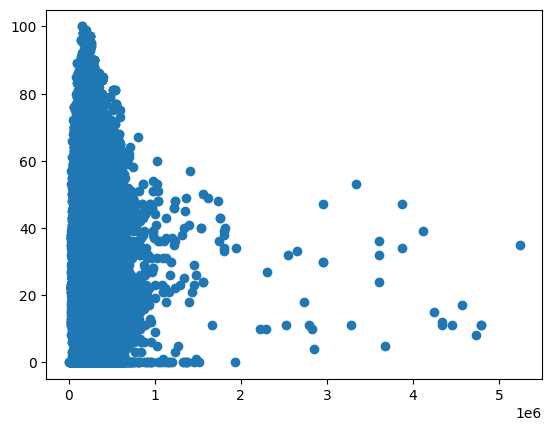

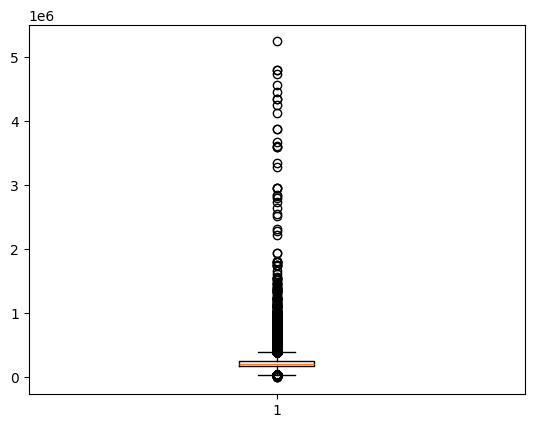

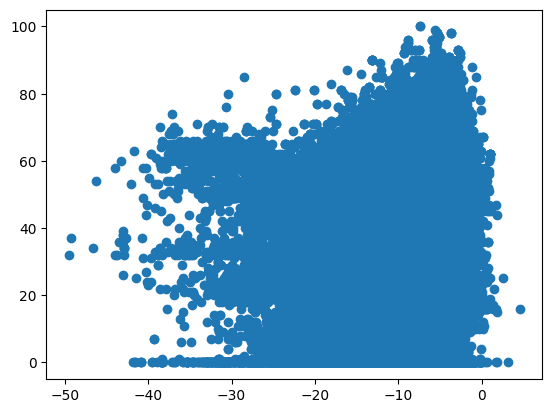

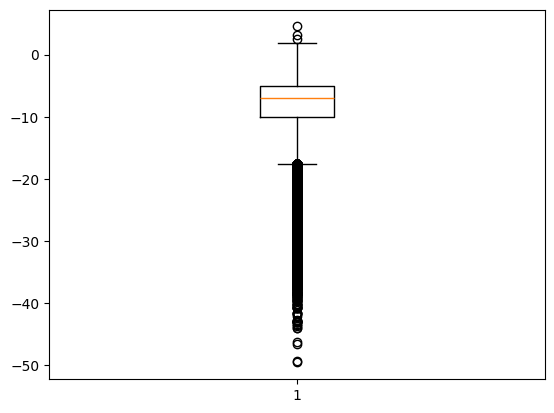

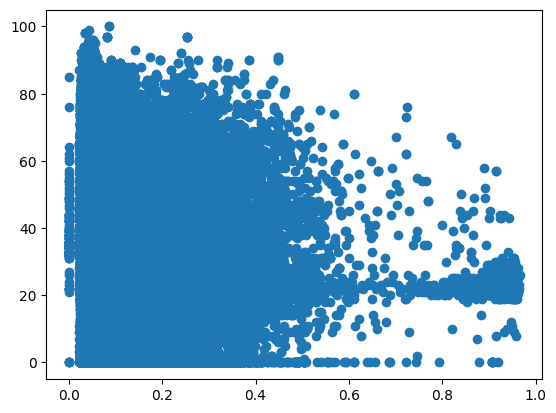

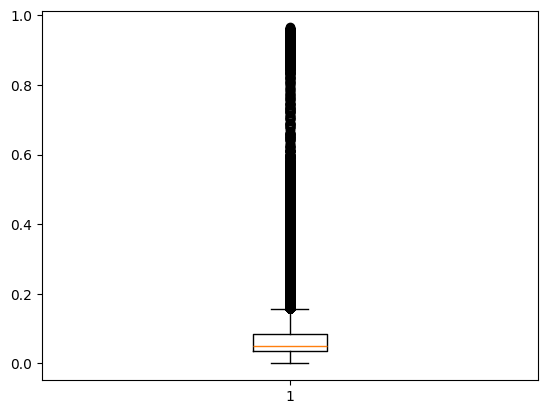

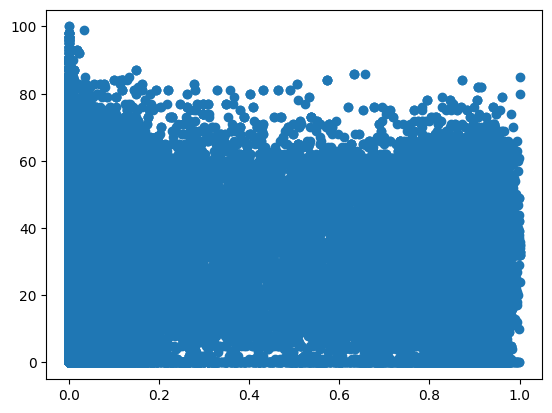

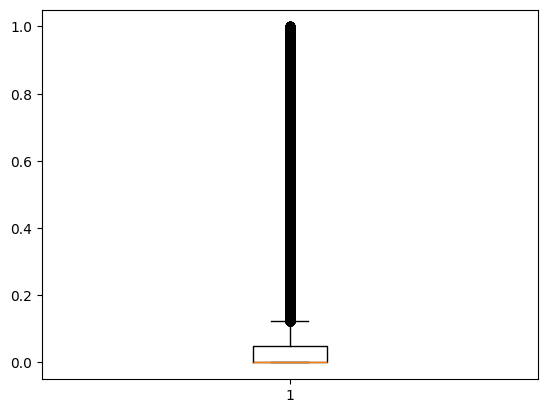

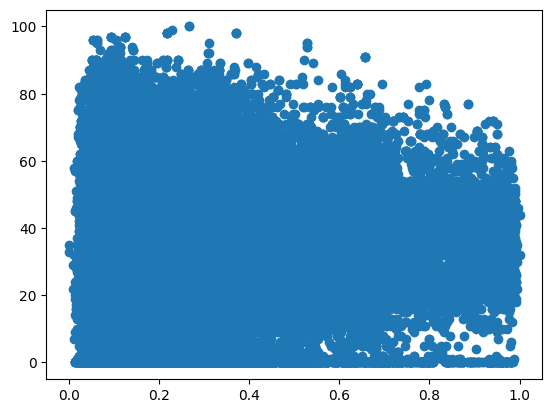

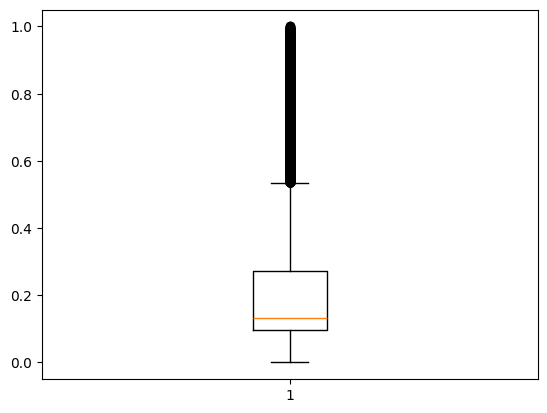

In [25]:
for var in vars_log: 
    plt.scatter(data=df_og, x=var, y=target)
    plt.show()
    
    plt.boxplot(data=df_og, x=var)
    plt.show()

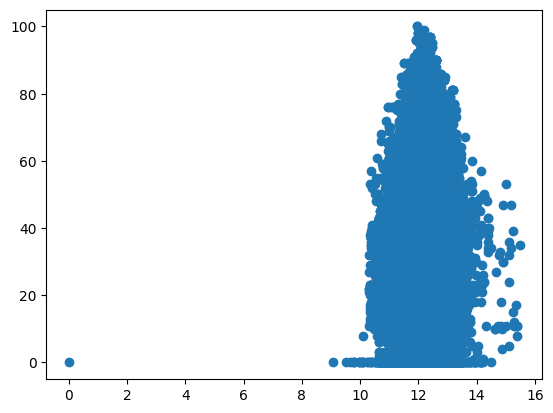

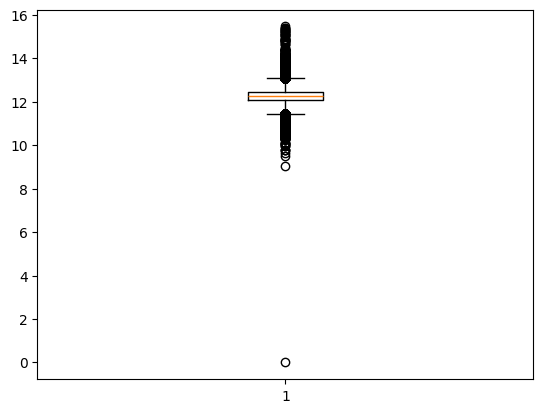

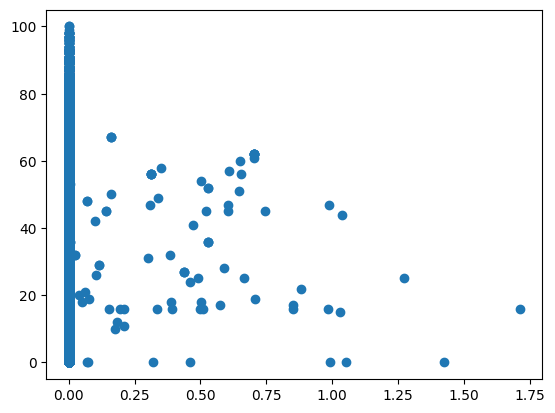

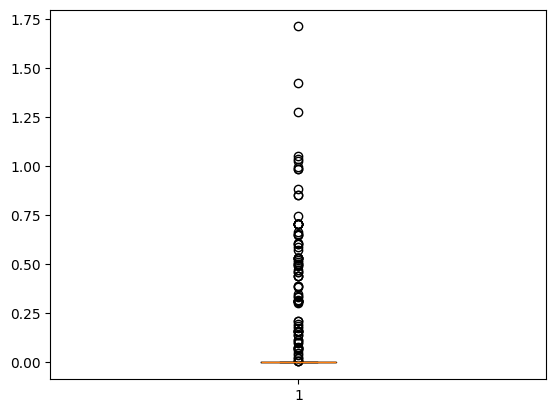

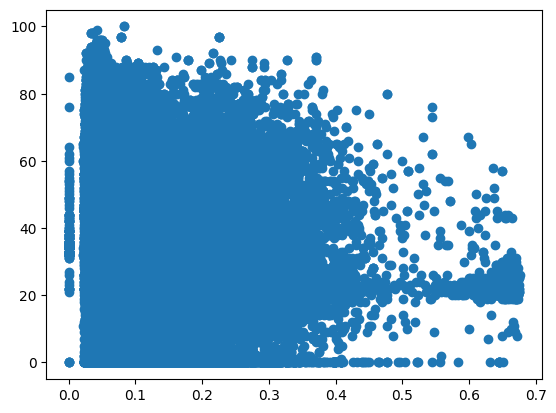

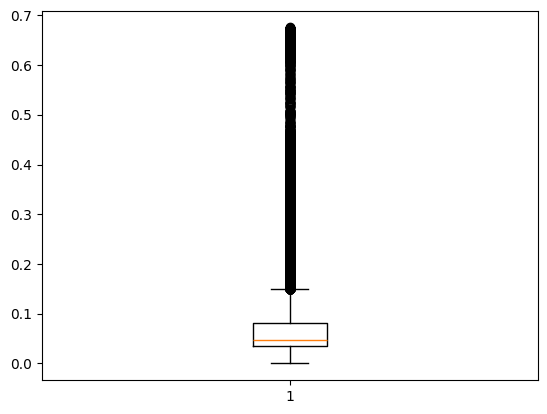

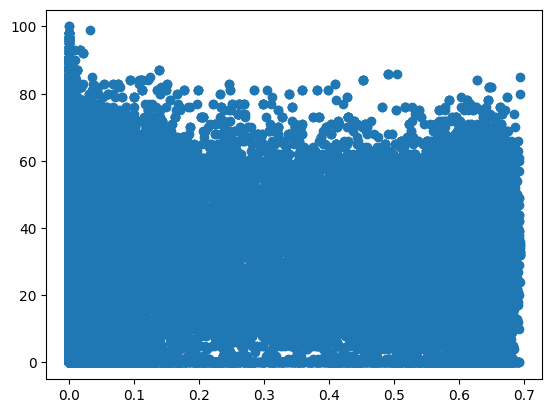

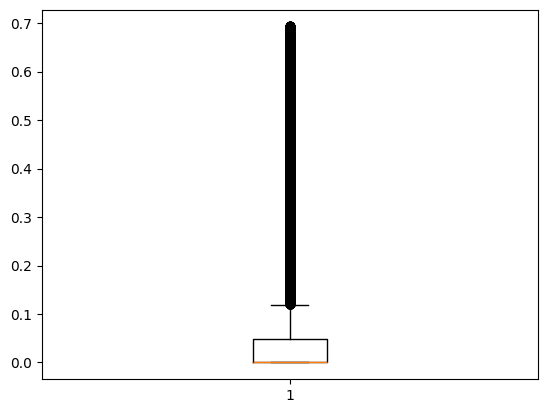

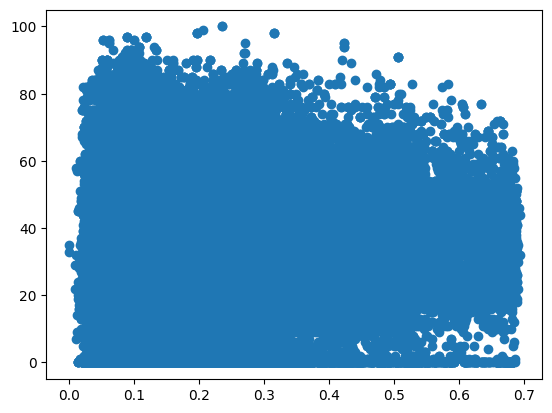

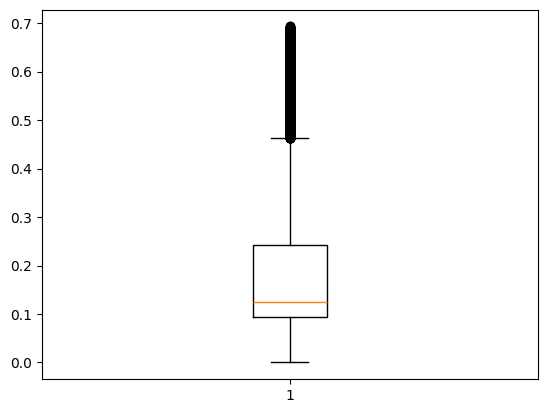

In [26]:
for var in vars_log:
    df_og[var] = df_og[var].apply(lambda x: np.log1p(x) if x > 0 else 0)
    plt.scatter(data=df_og, x=var, y=target)
    plt.show()
    
    plt.boxplot(data=df_og, x=var)
    plt.show()

In [27]:
if LOG:
    for var in vars_log:
        df[var] = df[var].apply(lambda x: np.log1p(x) if x > 0 else 0)

if WIND: # We "clip" the outliers out and we leave those values in the maximum/minimum value before them that's not considered an outlier
    for var in vars_wind:
        # Determine the lower and upper bounds of the non-outlier values
        iqr = df[var].quantile(0.75) - df[var].quantile(0.25)
        lower_bound = df[var].quantile(0.25) - 1.5 * iqr
        upper_bound = df[var].quantile(0.75) + 1.5 * iqr

        df[var] = df[var].clip(upper=upper_bound, lower=lower_bound)

display(df)

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,popularity
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic,1
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,acoustic,1
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,acoustic,1
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,acoustic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music,0
111426,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music,0
111427,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music,0
111428,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,world-music,1


In [28]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

num_cols.remove(target)

In [29]:
"""
We select some features which present very little correlation with the target variable and we take them out of the features that we will end up using.
"""

if SEL:
    cols_remove = ["duration_ms", "major", "acousticness", "liveness"]
    num_cols = [col for col in num_cols if col not in cols_remove]

In [30]:
"""
The features which are still defined in categories are: (unique)track_id, artists, album_name, track_name and track_genre.

Out of those, we can only realistically use track_genre. Any other of those variables is more of an identification variable.
Any predictive power that could come from those variables would probably have it because of being from a specific genre or from another one.
An artist who usually produces edm might have most of their tracks as highly danceable, but if they suddenly release an album of piano ballads, that could change
for that album specifically. Granted, this change in danceability would be captured by the album variable, but it would also be captured by the track_genre variable anyway.

To sum up, we are only keeping track_genre for reasons of avoiding having unmanageable dimensionality and to prevent the model to rely too much on features it can't be trained on
when making predictions for unseen data (newly released tracks).
"""

df = df.drop(columns=["track_id", "artists", "album_name", "track_name"])
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
df

,duration_ms,explicit,danceability,energy,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,popularity
0,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic,1
1,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic,1
2,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,acoustic,1
3,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,acoustic,1
4,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,acoustic,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111425,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music,0
111426,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music,0
111427,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music,0
111428,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,world-music,1


In [31]:
full_cols = num_cols + cat_cols
print(full_cols)
print(num_cols)
print(cat_cols)

['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'major', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'track_genre']
['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'major', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
['track_genre']


In [32]:
"""
Standardization
"""

num_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

In [33]:
"""
Target Encoding track_genre
"""

target_encoder = TargetEncoder(target_type="binary", random_state=98)

# Perform target encoding for the track_genre variable
cat_pipe = Pipeline(steps=[
    ("target_encoder", target_encoder)
])

### Model Definition

In [34]:
lc = LogisticRegression(penalty="l2",
                        max_iter=1000,
                        n_jobs=-1,
                        random_state=98,
                        verbose=3)

rf = RandomForestClassifier(n_estimators=rf_n_estim,
                            max_depth=None,
                            min_samples_split=4,
                            min_samples_leaf=2,
                            n_jobs=-1,
                            random_state=98,
                            verbose=3)

gb = GradientBoostingClassifier(loss="log_loss",
                                n_estimators=gb_n_estim,
                                min_samples_split=4,
                                min_samples_leaf=2,
                                max_depth=None,
                                learning_rate=0.1,
                                random_state=98,
                                verbose=3)

nn = MLPClassifier( hidden_layer_sizes=(10, 10),
                    activation="relu",
                    solver="adam",
                    max_iter=1000,
                    early_stopping=True,
                    n_iter_no_change=10,
                    random_state=98,
                    verbose=3)

svm = SVC(  kernel="rbf",
            C=0.1,
            gamma="scale",
            probability=True,
            random_state=98,
            verbose=3)



if MODEL == "LC":
    algo = lc
elif MODEL == "RF":
    algo = rf
elif MODEL == "GB":
    algo = gb
elif MODEL == "NN":
    algo = nn
elif MODEL == "SVM":
    algo = svm
else:
    raise ValueError("Invalid model selection. Please choose a valid model. Options are: LC, RF, GB, NN, SVM.")



if NORM and GENRE:
    preprocessing = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols)
        ]
    )
elif NORM and not GENRE:
    preprocessing = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols)
        ]
    )

    df = df.drop(columns=cat_cols).copy()
elif GENRE and not NORM:
    preprocessing = ColumnTransformer(
        transformers=[
            ("cat", cat_pipe, cat_cols)
        ]
    )
else:
    df = df.drop(columns=cat_cols).copy()

if not GENRE and not NORM:
    model = Pipeline(steps=[
        ("classifier", algo)
    ])
else:
    model = Pipeline(steps=[
        ("preprocess", preprocessing),
        ("classifier", algo)
    ])

### Data Split, Fit and Predict

In [35]:
X = df.drop(columns=[target])
y = df[target].copy()

display(X)
display(y)

,duration_ms,explicit,danceability,energy,loudness,major,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917
1,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489
2,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332
3,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740
4,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949
...,...,...,...,...,...,...,...,...,...,...,...,...
111425,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995
111426,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239
111427,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378
111428,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960


0         1
1         1
2         1
3         1
4         1
         ..
111425    0
111426    0
111427    0
111428    1
111429    0
Name: popularity, Length: 111430, dtype: int64

In [36]:
# We split the data here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98, stratify=y)

display(y_test.head())

# Now we recover the original target variable from df_target_copy using the indexes of the test set
y_test_og = df_target_copy.loc[y_test.index]
y_test_og = y_test_og.apply(lambda x: x/100)
display(y_test_og.head())

4524     0
11228    1
44300    0
8975     1
67685    1
Name: popularity, dtype: int64

4524     0.28
11228    0.23
44300    0.54
8975     0.50
67685    0.00
Name: popularity, dtype: float64

In [37]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/guillemmirabentrubinat/Documents/BSE/zz Teaching/Machine Learning/ML_TA_Sessions/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Model Evaluation

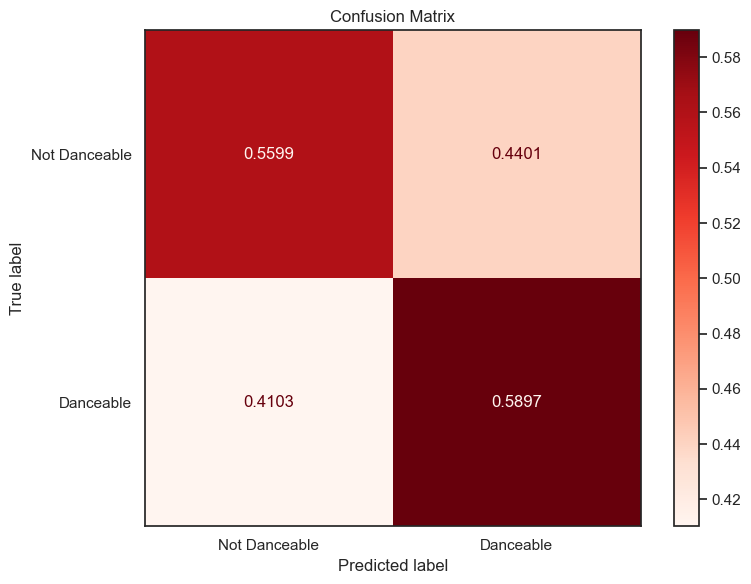

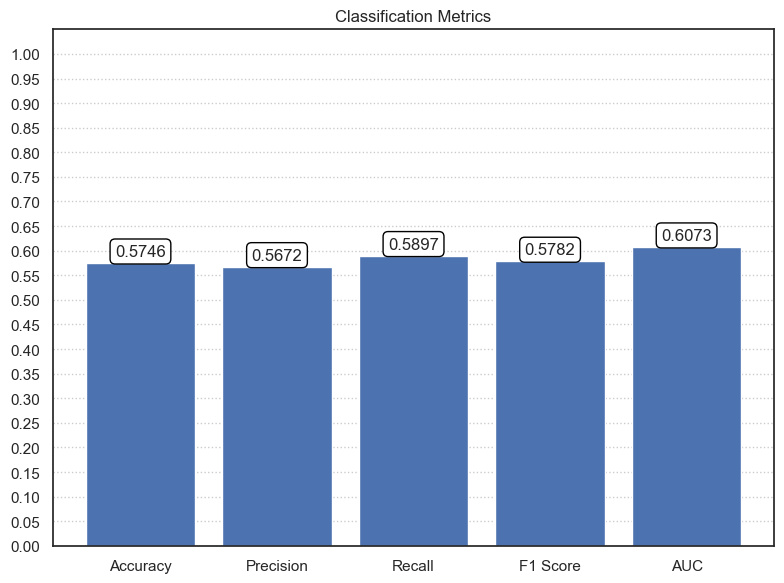

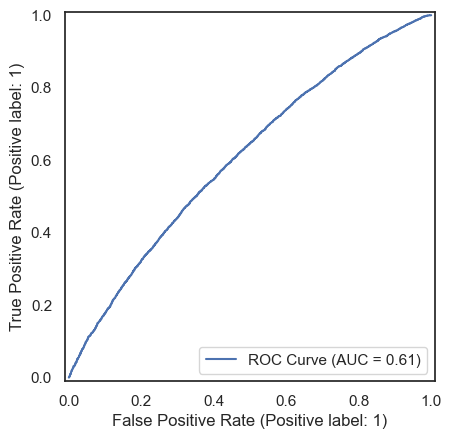

In [38]:
# We print the plots to analyze the model performance

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

sns.set_theme(style="white")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Danceable", "Danceable"])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Reds", ax=ax, values_format='.4f')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    x=["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    height=[acc, prec, rec, f1, auc])
ax.bar_label(
    bars,
    fmt="%.4f",
    label_type="edge",
    fontsize=12,
    padding=3,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))
ax.set_ylim(0, 1.05)
ax.set_yticks(np.arange(0, 1.05, 0.05))
ax.set_title("Classification Metrics")
ax.grid(True, axis="y", linestyle=":")
plt.tight_layout()
plt.show()

roc_plot = RocCurveDisplay.from_predictions(y_test, y_proba, name="ROC Curve")